In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(0, "..")


# Introdução

In [13]:
data = pd.read_csv("../data/creditcard.csv")

In [14]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
FEATURES = [f'V{i}' for i in range(1,29)] + ['Amount']
TARGET = 'Class'
SEED = 42


In [16]:
data['label'] = data.Class.apply(lambda x: "Fraud" if x==1 else "Not Fraud")

In [17]:
data_train, data_test = train_test_split(data, test_size=0.25, stratify=data[TARGET], random_state=SEED)

# EDA

## Describe

In [ ]:
data_train[FEATURES].describe().style.format('{:.3f}')

## Scatter Plot

<Axes: xlabel='V4', ylabel='V14'>

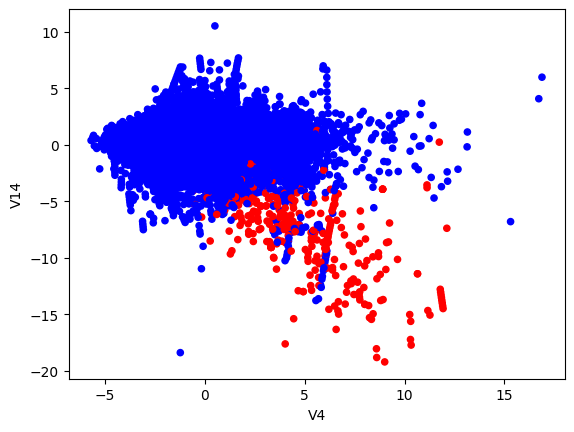

In [55]:
col = data_train.Class.map({0:'b', 1:'r'})
data_train.plot.scatter(x='V4',y='V14',c=col)

## Temporal Stability

In [18]:
data_train['time_hr'] = np.floor(data_train['Time']/3600)
data_train['time_hr']= data_train['time_hr'].astype(int)

In [19]:
data_agg_time = data_train.groupby(['time_hr']).agg(avg_amount=('Amount','mean'),
                              count=('Time','count'),
                              bad=('Class','sum')
                              ).reset_index()

In [20]:
from src.report import plot_time_stab, bin_var

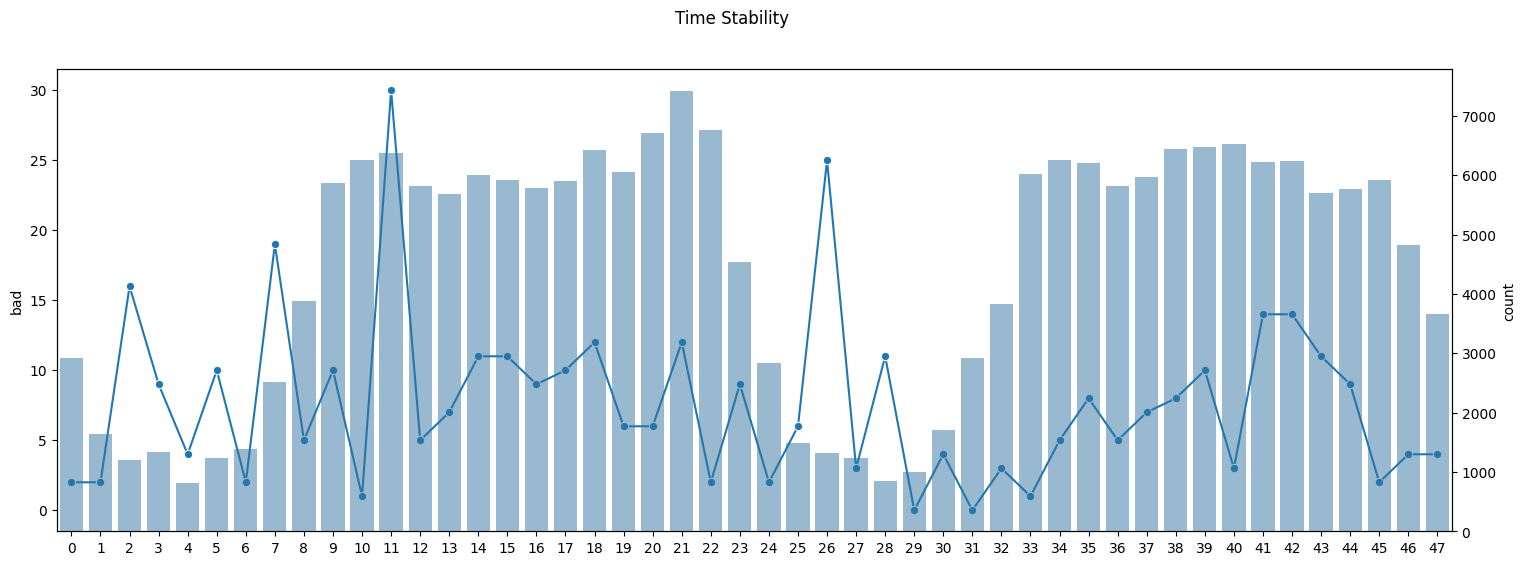

In [21]:
plot_time_stab(data_agg_time)

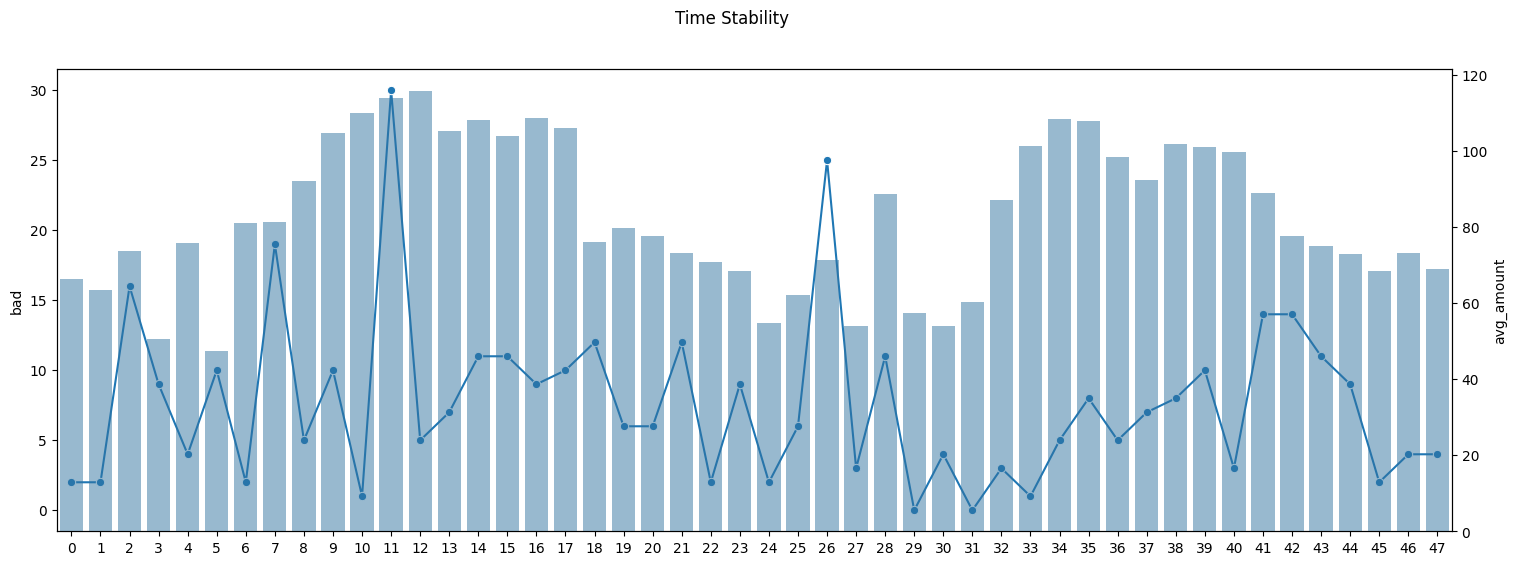

In [22]:
plot_time_stab(data_agg_time, bar_y_col='avg_amount')

## Binned Variables

In [60]:
def _bin_var(data, col, n_bins=10): 
    df = data.copy()
    col_binned = col+'_binned'
    cmap = sns.light_palette("red", as_cmap=True)
    df[col_binned] = pd.qcut(df[col],q=n_bins)
    df_agg = df.groupby(col_binned).agg(
                              count=(col,'count'),
                              bad=('Class','sum')
                              ).reset_index()
    df_agg['bad_rate'] = df_agg.bad/df_agg['count']
    df_agg['bad_distr'] = df_agg.bad/df_agg.bad.sum()
    view  = df_agg.style.background_gradient(subset=['bad_rate','bad_distr'],cmap=cmap,vmax=1).format("{:.3f}",subset=["bad_rate","bad_distr"])
    return view

In [61]:
for f in FEATURES:
    print(f)
    display(_bin_var(data,f))

V1


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V1_binned,count,bad,bad_rate,bad_distr
0,"(-56.409, -1.893]",28481,276,0.010,0.561
1,"(-1.893, -1.135]",28481,50,0.002,0.102
2,"(-1.135, -0.747]",28480,25,0.001,0.051
3,"(-0.747, -0.427]",28481,17,0.001,0.035
4,"(-0.427, 0.0181]",28481,20,0.001,0.041
5,"(0.0181, 1.035]",28480,53,0.002,0.108
6,"(1.035, 1.225]",28481,27,0.001,0.055
7,"(1.225, 1.695]",28480,10,0.000,0.020
8,"(1.695, 2.015]",28481,12,0.000,0.024
9,"(2.015, 2.455]",28481,2,0.000,0.004


V2


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V2_binned,count,bad,bad_rate,bad_distr
0,"(-72.717, -1.36]",28481,23,0.001,0.047
1,"(-1.36, -0.791]",28481,9,0.000,0.018
2,"(-0.791, -0.436]",28480,8,0.000,0.016
3,"(-0.436, -0.154]",28481,7,0.000,0.014
4,"(-0.154, 0.0655]",28481,11,0.000,0.022
5,"(0.0655, 0.303]",28480,6,0.000,0.012
6,"(0.303, 0.637]",28481,17,0.001,0.035
7,"(0.637, 0.957]",28480,16,0.001,0.033
8,"(0.957, 1.327]",28481,39,0.001,0.079
9,"(1.327, 22.058]",28481,356,0.012,0.724


V3


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V3_binned,count,bad,bad_rate,bad_distr
0,"(-48.327, -1.803]",28481,389,0.014,0.791
1,"(-1.803, -1.169]",28481,28,0.001,0.057
2,"(-1.169, -0.617]",28480,20,0.001,0.041
3,"(-0.617, -0.199]",28481,17,0.001,0.035
4,"(-0.199, 0.18]",28481,9,0.000,0.018
5,"(0.18, 0.497]",28480,6,0.000,0.012
6,"(0.497, 0.844]",28481,8,0.000,0.016
7,"(0.844, 1.216]",28480,9,0.000,0.018
8,"(1.216, 1.676]",28481,2,0.000,0.004
9,"(1.676, 9.383]",28481,4,0.000,0.008


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V4


,V4_binned,count,bad,bad_rate,bad_distr
0,"(-5.684, -1.656]",28481,0,0.000,0.000
1,"(-1.656, -1.066]",28481,2,0.000,0.004
2,"(-1.066, -0.696]",28480,1,0.000,0.002
3,"(-0.696, -0.394]",28481,5,0.000,0.010
4,"(-0.394, -0.0198]",28481,5,0.000,0.010
5,"(-0.0198, 0.285]",28480,10,0.000,0.020
6,"(0.285, 0.559]",28481,9,0.000,0.018
7,"(0.559, 0.986]",28480,13,0.000,0.026
8,"(0.986, 1.483]",28481,25,0.001,0.051
9,"(1.483, 16.875]",28481,422,0.015,0.858


V5


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V5_binned,count,bad,bad_rate,bad_distr
0,"(-113.744, -1.302]",28481,256,0.009,0.520
1,"(-1.302, -0.86]",28481,34,0.001,0.069
2,"(-0.86, -0.544]",28480,27,0.001,0.055
3,"(-0.544, -0.29]",28481,18,0.001,0.037
4,"(-0.29, -0.0543]",28481,16,0.001,0.033
5,"(-0.0543, 0.187]",28480,15,0.001,0.030
6,"(0.187, 0.457]",28481,21,0.001,0.043
7,"(0.457, 0.802]",28481,24,0.001,0.049
8,"(0.802, 1.408]",28480,33,0.001,0.067
9,"(1.408, 34.802]",28481,48,0.002,0.098


V6


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V6_binned,count,bad,bad_rate,bad_distr
0,"(-26.162000000000003, -1.167]",28481,284,0.010,0.577
1,"(-1.167, -0.878]",28481,32,0.001,0.065
2,"(-0.878, -0.668]",28480,22,0.001,0.045
3,"(-0.668, -0.479]",28481,26,0.001,0.053
4,"(-0.479, -0.274]",28481,21,0.001,0.043
5,"(-0.274, -0.0482]",28480,25,0.001,0.051
6,"(-0.0482, 0.223]",28481,19,0.001,0.039
7,"(0.223, 0.629]",28480,15,0.001,0.030
8,"(0.629, 1.509]",28481,27,0.001,0.055
9,"(1.509, 73.302]",28481,21,0.001,0.043


V7


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V7_binned,count,bad,bad_rate,bad_distr
0,"(-43.558, -1.078]",28481,364,0.013,0.740
1,"(-1.078, -0.683]",28481,23,0.001,0.047
2,"(-0.683, -0.426]",28480,7,0.000,0.014
3,"(-0.426, -0.159]",28481,6,0.000,0.012
4,"(-0.159, 0.0401]",28481,11,0.000,0.022
5,"(0.0401, 0.214]",28480,8,0.000,0.016
6,"(0.214, 0.446]",28481,20,0.001,0.041
7,"(0.446, 0.698]",28480,10,0.000,0.020
8,"(0.698, 1.039]",28481,10,0.000,0.020
9,"(1.039, 120.589]",28481,33,0.001,0.067


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V8


,V8_binned,count,bad,bad_rate,bad_distr
0,"(-73.218, -0.459]",28481,93,0.003,0.189
1,"(-0.459, -0.266]",28481,21,0.001,0.043
2,"(-0.266, -0.158]",28480,13,0.000,0.026
3,"(-0.158, -0.0661]",28481,13,0.000,0.026
4,"(-0.0661, 0.0224]",28481,12,0.000,0.024
5,"(0.0224, 0.12]",28480,21,0.001,0.043
6,"(0.12, 0.243]",28481,19,0.001,0.039
7,"(0.243, 0.436]",28480,27,0.001,0.055
8,"(0.436, 0.769]",28481,55,0.002,0.112
9,"(0.769, 20.007]",28481,218,0.008,0.443


V9


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V9_binned,count,bad,bad_rate,bad_distr
0,"(-13.434999999999999, -1.294]",28481,327,0.011,0.665
1,"(-1.294, -0.809]",28481,38,0.001,0.077
2,"(-0.809, -0.502]",28480,29,0.001,0.059
3,"(-0.502, -0.258]",28481,18,0.001,0.037
4,"(-0.258, -0.0514]",28481,19,0.001,0.039
5,"(-0.0514, 0.176]",28480,14,0.000,0.028
6,"(0.176, 0.446]",28481,10,0.000,0.020
7,"(0.446, 0.792]",28480,12,0.000,0.024
8,"(0.792, 1.302]",28481,18,0.001,0.037
9,"(1.302, 15.595]",28481,7,0.000,0.014


V10


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V10_binned,count,bad,bad_rate,bad_distr
0,"(-24.589000000000002, -1.032]",28481,417,0.015,0.848
1,"(-1.032, -0.666]",28481,12,0.000,0.024
2,"(-0.666, -0.426]",28480,7,0.000,0.014
3,"(-0.426, -0.248]",28481,7,0.000,0.014
4,"(-0.248, -0.0929]",28481,7,0.000,0.014
5,"(-0.0929, 0.0595]",28480,6,0.000,0.012
6,"(0.0595, 0.27]",28481,9,0.000,0.018
7,"(0.27, 0.648]",28480,11,0.000,0.022
8,"(0.648, 1.12]",28481,7,0.000,0.014
9,"(1.12, 23.745]",28481,9,0.000,0.018


V11


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V11_binned,count,bad,bad_rate,bad_distr
0,"(-4.798, -1.289]",28481,7,0.000,0.014
1,"(-1.289, -0.917]",28481,6,0.000,0.012
2,"(-0.917, -0.613]",28480,5,0.000,0.010
3,"(-0.613, -0.317]",28481,10,0.000,0.020
4,"(-0.317, -0.0328]",28481,3,0.000,0.006
5,"(-0.0328, 0.268]",28480,10,0.000,0.020
6,"(0.268, 0.579]",28481,9,0.000,0.018
7,"(0.579, 0.913]",28480,15,0.001,0.030
8,"(0.913, 1.319]",28481,23,0.001,0.047
9,"(1.319, 12.019]",28481,404,0.014,0.821


V12


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V12_binned,count,bad,bad_rate,bad_distr
0,"(-18.685000000000002, -1.148]",28481,414,0.015,0.841
1,"(-1.148, -0.573]",28481,23,0.001,0.047
2,"(-0.573, -0.272]",28481,20,0.001,0.041
3,"(-0.272, -0.0505]",28480,8,0.000,0.016
4,"(-0.0505, 0.14]",28481,6,0.000,0.012
5,"(0.14, 0.325]",28480,7,0.000,0.014
6,"(0.325, 0.516]",28481,3,0.000,0.006
7,"(0.516, 0.731]",28480,3,0.000,0.006
8,"(0.731, 1.017]",28481,6,0.000,0.012
9,"(1.017, 7.848]",28481,2,0.000,0.004


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V13


,V13_binned,count,bad,bad_rate,bad_distr
0,"(-5.793, -1.28]",28481,74,0.003,0.150
1,"(-1.28, -0.825]",28481,67,0.002,0.136
2,"(-0.825, -0.497]",28480,39,0.001,0.079
3,"(-0.497, -0.24]",28481,36,0.001,0.073
4,"(-0.24, -0.0136]",28481,33,0.001,0.067
5,"(-0.0136, 0.229]",28480,37,0.001,0.075
6,"(0.229, 0.505]",28481,52,0.002,0.106
7,"(0.505, 0.829]",28480,58,0.002,0.118
8,"(0.829, 1.252]",28481,41,0.001,0.083
9,"(1.252, 7.127]",28481,55,0.002,0.112


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V14


,V14_binned,count,bad,bad_rate,bad_distr
0,"(-19.215, -1.004]",28481,445,0.016,0.904
1,"(-1.004, -0.567]",28481,12,0.000,0.024
2,"(-0.567, -0.312]",28480,7,0.000,0.014
3,"(-0.312, -0.12]",28481,3,0.000,0.006
4,"(-0.12, 0.0506]",28481,3,0.000,0.006
5,"(0.0506, 0.216]",28480,3,0.000,0.006
6,"(0.216, 0.394]",28481,4,0.000,0.008
7,"(0.394, 0.609]",28480,2,0.000,0.004
8,"(0.609, 0.981]",28481,3,0.000,0.006
9,"(0.981, 10.527]",28481,10,0.000,0.020


V15


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V15_binned,count,bad,bad_rate,bad_distr
0,"(-4.5, -1.174]",28481,74,0.003,0.150
1,"(-1.174, -0.749]",28481,37,0.001,0.075
2,"(-0.749, -0.439]",28480,39,0.001,0.079
3,"(-0.439, -0.189]",28481,66,0.002,0.134
4,"(-0.189, 0.0481]",28481,55,0.002,0.112
5,"(0.0481, 0.272]",28503,30,0.001,0.061
6,"(0.272, 0.514]",28458,45,0.002,0.091
7,"(0.514, 0.795]",28480,47,0.002,0.096
8,"(0.795, 1.124]",28481,52,0.002,0.106
9,"(1.124, 8.878]",28481,47,0.002,0.096


V16


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V16_binned,count,bad,bad_rate,bad_distr
0,"(-14.131, -1.059]",28481,377,0.013,0.766
1,"(-1.059, -0.616]",28481,21,0.001,0.043
2,"(-0.616, -0.343]",28480,9,0.000,0.018
3,"(-0.343, -0.125]",28481,3,0.000,0.006
4,"(-0.125, 0.0664]",28481,5,0.000,0.010
5,"(0.0664, 0.242]",28480,9,0.000,0.018
6,"(0.242, 0.426]",28481,9,0.000,0.018
7,"(0.426, 0.641]",28480,11,0.000,0.022
8,"(0.641, 0.991]",28481,14,0.000,0.028
9,"(0.991, 17.315]",28481,34,0.001,0.069


V17


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V17_binned,count,bad,bad_rate,bad_distr
0,"(-25.164, -0.804]",28481,378,0.013,0.768
1,"(-0.804, -0.576]",28481,1,0.000,0.002
2,"(-0.576, -0.397]",28480,3,0.000,0.006
3,"(-0.397, -0.236]",28481,2,0.000,0.004
4,"(-0.236, -0.0657]",28481,7,0.000,0.014
5,"(-0.0657, 0.105]",28480,6,0.000,0.012
6,"(0.105, 0.297]",28481,8,0.000,0.016
7,"(0.297, 0.519]",28480,7,0.000,0.014
8,"(0.519, 0.909]",28481,21,0.001,0.043
9,"(0.909, 9.254]",28481,59,0.002,0.120


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V18


,V18_binned,count,bad,bad_rate,bad_distr
0,"(-9.5, -0.977]",28481,293,0.010,0.596
1,"(-0.977, -0.627]",28481,27,0.001,0.055
2,"(-0.627, -0.386]",28480,13,0.000,0.026
3,"(-0.386, -0.186]",28481,10,0.000,0.020
4,"(-0.186, -0.00364]",28481,20,0.001,0.041
5,"(-0.00364, 0.182]",28480,17,0.001,0.035
6,"(0.182, 0.383]",28481,24,0.001,0.049
7,"(0.383, 0.637]",28480,17,0.001,0.035
8,"(0.637, 1.02]",28481,20,0.001,0.041
9,"(1.02, 5.041]",28481,51,0.002,0.104


V19


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V19_binned,count,bad,bad_rate,bad_distr
0,"(-7.215000000000001, -0.986]",28481,75,0.003,0.152
1,"(-0.986, -0.583]",28481,25,0.001,0.051
2,"(-0.583, -0.345]",28480,21,0.001,0.043
3,"(-0.345, -0.162]",28481,16,0.001,0.033
4,"(-0.162, 0.00373]",28481,14,0.000,0.028
5,"(0.00373, 0.168]",28480,24,0.001,0.049
6,"(0.168, 0.348]",28481,21,0.001,0.043
7,"(0.348, 0.586]",28480,35,0.001,0.071
8,"(0.586, 0.954]",28481,59,0.002,0.120
9,"(0.954, 5.592]",28481,202,0.007,0.411


V20


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V20_binned,count,bad,bad_rate,bad_distr
0,"(-54.498999999999995, -0.39]",28481,80,0.003,0.163
1,"(-0.39, -0.251]",28481,16,0.001,0.033
2,"(-0.251, -0.179]",28480,22,0.001,0.045
3,"(-0.179, -0.121]",28481,21,0.001,0.043
4,"(-0.121, -0.0625]",28481,18,0.001,0.037
5,"(-0.0625, 0.00431]",28480,21,0.001,0.043
6,"(0.00431, 0.0834]",28481,19,0.001,0.039
7,"(0.0834, 0.196]",28480,22,0.001,0.045
8,"(0.196, 0.445]",28481,80,0.003,0.163
9,"(0.445, 39.421]",28481,193,0.007,0.392


V21


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V21_binned,count,bad,bad_rate,bad_distr
0,"(-34.830999999999996, -0.367]",28481,70,0.002,0.142
1,"(-0.367, -0.266]",28481,14,0.000,0.028
2,"(-0.266, -0.188]",28480,1,0.000,0.002
3,"(-0.188, -0.106]",28481,13,0.000,0.026
4,"(-0.106, -0.0295]",28481,15,0.001,0.030
5,"(-0.0295, 0.0504]",28480,11,0.000,0.022
6,"(0.0504, 0.138]",28481,15,0.001,0.030
7,"(0.138, 0.235]",28480,19,0.001,0.039
8,"(0.235, 0.376]",28481,35,0.001,0.071
9,"(0.376, 27.203]",28481,299,0.010,0.608


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V22


,V22_binned,count,bad,bad_rate,bad_distr
0,"(-10.934, -0.867]",28481,66,0.002,0.134
1,"(-0.867, -0.642]",28481,35,0.001,0.071
2,"(-0.642, -0.434]",28480,46,0.002,0.093
3,"(-0.434, -0.202]",28481,47,0.002,0.096
4,"(-0.202, 0.00678]",28481,44,0.002,0.089
5,"(0.00678, 0.201]",28480,43,0.002,0.087
6,"(0.201, 0.413]",28481,45,0.002,0.091
7,"(0.413, 0.649]",28480,47,0.002,0.096
8,"(0.649, 0.915]",28481,44,0.002,0.089
9,"(0.915, 10.503]",28481,75,0.003,0.152


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V23


,V23_binned,count,bad,bad_rate,bad_distr
0,"(-44.809, -0.329]",28481,130,0.005,0.264
1,"(-0.329, -0.204]",28481,47,0.002,0.096
2,"(-0.204, -0.126]",28480,42,0.001,0.085
3,"(-0.126, -0.0651]",28481,28,0.001,0.057
4,"(-0.0651, -0.0112]",28481,29,0.001,0.059
5,"(-0.0112, 0.0448]",28480,21,0.001,0.043
6,"(0.0448, 0.109]",28481,23,0.001,0.047
7,"(0.109, 0.194]",28480,26,0.001,0.053
8,"(0.194, 0.339]",28481,28,0.001,0.057
9,"(0.339, 22.528]",28481,118,0.004,0.240


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


V24


,V24_binned,count,bad,bad_rate,bad_distr
0,"(-2.838, -0.87]",28481,40,0.001,0.081
1,"(-0.87, -0.444]",28481,80,0.003,0.163
2,"(-0.444, -0.264]",28480,65,0.002,0.132
3,"(-0.264, -0.0458]",28481,66,0.002,0.134
4,"(-0.0458, 0.041]",28481,33,0.001,0.067
5,"(0.041, 0.166]",28480,51,0.002,0.104
6,"(0.166, 0.374]",28481,59,0.002,0.120
7,"(0.374, 0.532]",28480,50,0.002,0.102
8,"(0.532, 0.705]",28481,30,0.001,0.061
9,"(0.705, 4.585]",28481,18,0.001,0.037


V25


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V25_binned,count,bad,bad_rate,bad_distr
0,"(-10.296, -0.606]",28481,75,0.003,0.152
1,"(-0.606, -0.392]",28481,34,0.001,0.069
2,"(-0.392, -0.258]",28480,30,0.001,0.061
3,"(-0.258, -0.129]",28481,39,0.001,0.079
4,"(-0.129, 0.0166]",28481,42,0.001,0.085
5,"(0.0166, 0.159]",28480,52,0.002,0.106
6,"(0.159, 0.285]",28481,39,0.001,0.079
7,"(0.285, 0.418]",28480,50,0.002,0.102
8,"(0.418, 0.601]",28481,45,0.002,0.091
9,"(0.601, 7.52]",28481,86,0.003,0.175


V26


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V26_binned,count,bad,bad_rate,bad_distr
0,"(-2.606, -0.548]",28481,36,0.001,0.073
1,"(-0.548, -0.39]",28481,39,0.001,0.079
2,"(-0.39, -0.274]",28480,35,0.001,0.071
3,"(-0.274, -0.166]",28481,67,0.002,0.136
4,"(-0.166, -0.0521]",28481,47,0.002,0.096
5,"(-0.0521, 0.0861]",28480,55,0.002,0.112
6,"(0.0861, 0.175]",28481,25,0.001,0.051
7,"(0.175, 0.36]",28480,55,0.002,0.112
8,"(0.36, 0.689]",28481,100,0.004,0.203
9,"(0.689, 3.517]",28481,33,0.001,0.067


V27


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V27_binned,count,bad,bad_rate,bad_distr
0,"(-22.567, -0.211]",28481,95,0.003,0.193
1,"(-0.211, -0.0911]",28481,15,0.001,0.030
2,"(-0.0911, -0.0542]",28480,5,0.000,0.010
3,"(-0.0542, -0.0244]",28481,7,0.000,0.014
4,"(-0.0244, 0.00134]",28481,13,0.000,0.026
5,"(0.00134, 0.0292]",28480,18,0.001,0.037
6,"(0.0292, 0.0632]",28481,15,0.001,0.030
7,"(0.0632, 0.135]",28480,20,0.001,0.041
8,"(0.135, 0.265]",28482,26,0.001,0.053
9,"(0.265, 31.612]",28480,278,0.010,0.565


V28


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,V28_binned,count,bad,bad_rate,bad_distr
0,"(-15.431, -0.156]",28481,111,0.004,0.226
1,"(-0.156, -0.0654]",28494,22,0.001,0.045
2,"(-0.0654, -0.0403]",28467,11,0.000,0.022
3,"(-0.0403, -0.012]",28481,8,0.000,0.016
4,"(-0.012, 0.0112]",28481,14,0.000,0.028
5,"(0.0112, 0.0269]",28480,6,0.000,0.012
6,"(0.0269, 0.0535]",28481,16,0.001,0.033
7,"(0.0535, 0.101]",28480,28,0.001,0.057
8,"(0.101, 0.18]",28481,48,0.002,0.098
9,"(0.18, 33.848]",28481,228,0.008,0.463


Amount


C:\Users\thoma\AppData\Local\Temp\ipykernel_484\3640863924.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,Amount_binned,count,bad,bad_rate,bad_distr
0,"(-0.001, 1.0]",30492,181,0.006,0.368
1,"(1.0, 3.57]",26473,27,0.001,0.055
2,"(3.57, 8.91]",28559,36,0.001,0.073
3,"(8.91, 13.0]",28405,13,0.000,0.026
4,"(13.0, 22.0]",28714,14,0.000,0.028
5,"(22.0, 37.0]",28375,17,0.001,0.035
6,"(37.0, 59.8]",28366,24,0.001,0.049
7,"(59.8, 100.0]",28915,50,0.002,0.102
8,"(100.0, 203.0]",28050,45,0.002,0.091
9,"(203.0, 25691.16]",28458,85,0.003,0.173


<Axes: xlabel='V4', ylabel='Density'>

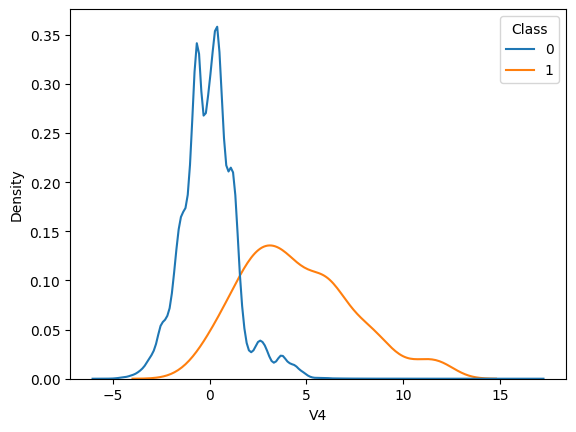

In [132]:
sns.kdeplot(data=data_train,x='V4', hue='Class', common_norm=False)

<Axes: xlabel='V14', ylabel='Density'>

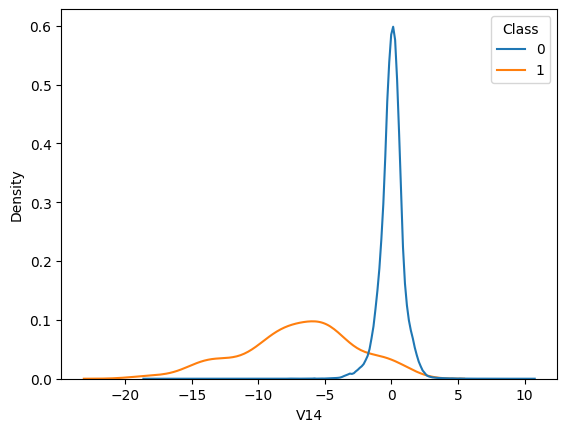

In [133]:
sns.kdeplot(data=data_train,x='V14', hue='Class', common_norm=False)

# Modeling

Modelagem:
    - Discutir as métricas 
        - AUC
        - F1
        - Recall
        - Precision 
        - Matriz de Confusão
        - Custo 
    - Discutir a metodologia
        - Uso de um baseline (Regressão Logística)
        - Modelo de boosting (catboost)
        - Calibração das probabilidades
            - Acrescentar que essa forma seria uma forma diferente de encarar o problema (integração com outros modelos, integrar com um mecanismo de decisão)
Conclusão
    - Salva o modelo joblib
    - API 
    Proximos Passos~
        - Passo de resampling para o hidden feedback loop
        - Sugestão de deploy 
        

## Baseline Model 
Vamos utilizar como modelo baseline regressão logística com undersampling selecionando com LASSO


In [27]:
from sklearn.linear_model import lasso_path, LogisticRegression
from src.model import undersampling, calc_metrics
from itertools import cycle


In [28]:
def calc_metrics(y_true, y_pred):
    recall = recall_score(y_true,y_pred)
    precision = precision_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)

    

    df_metrics = pd.DataFrame({'recall': {'value':recall},
                               'precision': {'value':precision},
                               'f1': {'value':f1}})
    
    return df_metrics

In [29]:
def conf_mat(y_true, y_pred, figsize=(5,5)): 
    conf_mat = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(conf_mat, index=np.unique(y_true), columns=np.unique(y_true))
    # annt = conf_mat.astype(str)
    group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        (conf_mat.T/np.sum(conf_mat,axis=1)).T.flatten()]
    labels = [f"{c}\n{perc}" for c, perc in
            zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    
    return sns.heatmap(cm, cmap= "YlGnBu",annot=labels,fmt='',  ax=ax)


In [30]:
# def undersampling(df, prop=None,target='Class'):
#     c_min = df['Class'].value_counts().argmin()
    
#     if not prop:
#         n_class_min = df['Class'].value_counts().min()
#         prop = n_class_min/df.shape[0]

#     df_min = df[df[target]==c_min]
#     df_max = df[df[target]!=c_min]

#     n=int(prop*df.shape[0])
#     df_max_resampled = df_max.sample(n, random_state=SEED)
    
#     return pd.concat([df_max_resampled,df_min])

In [31]:
data_resampled = undersampling(data_train)

In [32]:
alphas_lasso, coefs_lasso, _ = lasso_path(data_train[FEATURES], data_train[TARGET], eps=1e-5)

(1.1462643629606724e-06,
 0.3624806187637676,
 -0.017504996561867017,
 0.007572452554274949)

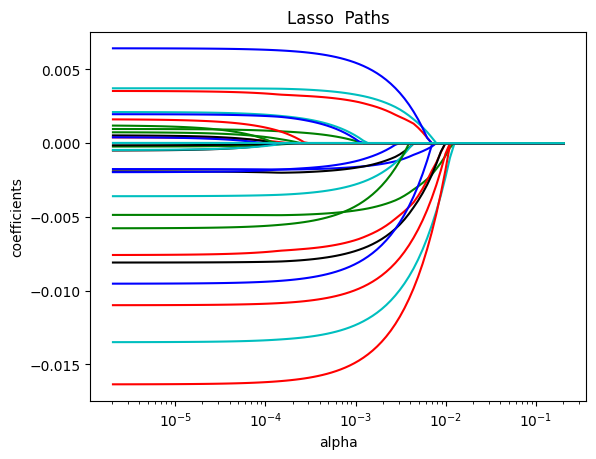

In [33]:
colors = cycle(["b", "r", "g", "c", "k"])
for coef_l, c in zip(coefs_lasso, colors):
    l1 = plt.semilogx(alphas_lasso, coef_l, c=c)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso  Paths")
# plt.legend((l1[-1], ("Lasso", "Elastic-Net"), loc="lower right")
plt.axis("tight")

In [34]:
coefs_lasso.shape

(29, 100)

In [35]:
top_k_fetures = np.argsort((coefs_lasso==0).sum(axis=1))

In [36]:
sel_feat_idx = top_k_fetures[:10]
# sel_feat = FEATURES[sel_feat_idx]

In [37]:
sel_feat = np.array(FEATURES)[sel_feat_idx]

In [38]:
model_baseline = LogisticRegression()


In [120]:
# X_train = data_resampled[sel_feat]
# y_train = data_resampled[TARGET]
X_train = data_train[FEATURES]
y_train = data_train[TARGET]

X_test = data_test[FEATURES]
y_test = data_test[TARGET]

model_baseline.fit(X_train,y_train)

c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\fraud-detection-ofJXJpq--py3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [121]:
# X_test = data_test[sel_feat]
# y_test = data_test[TARGET]
y_pred = model_baseline.predict(X_test)
scores = model_baseline.predict_proba(X_test)[:,1]

In [41]:
met = calc_metrics(y_test, y_pred )
met

,recall,precision,f1
value,0.918699,0.044611,0.08509


<Axes: xlabel='Predicted', ylabel='Actual'>

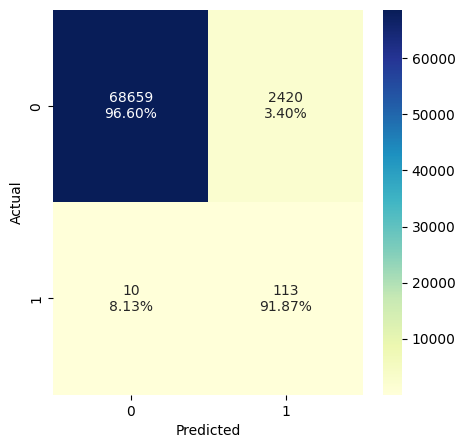

In [42]:
conf_mat(y_test, y_pred)

## Boosting Model

In [93]:
from catboost import CatBoostClassifier

In [94]:
X_train = data_train[FEATURES]
y_train = data_train[TARGET]

X_test = data_test[FEATURES]
y_test = data_test[TARGET]

In [95]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)
clf.fit(X_train, y_train)

In [129]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [97]:
met = calc_metrics(y_test, y_pred )
met

,recall,precision,f1
value,0.821138,0.795276,0.808


<Axes: xlabel='Predicted', ylabel='Actual'>

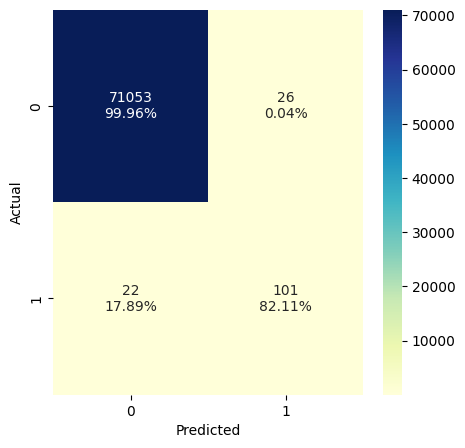

In [98]:
conf_mat(y_test, y_pred)

## Calibração

In [109]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

In [113]:
calibrated_clf = CalibratedClassifierCV(clf, cv=3)


In [114]:
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=<catboost.core.CatBoostClassifier object at 0x000002B7599235E0>)

In [118]:
scores = calibrated_clf.predict_proba(X_test)[:,1]

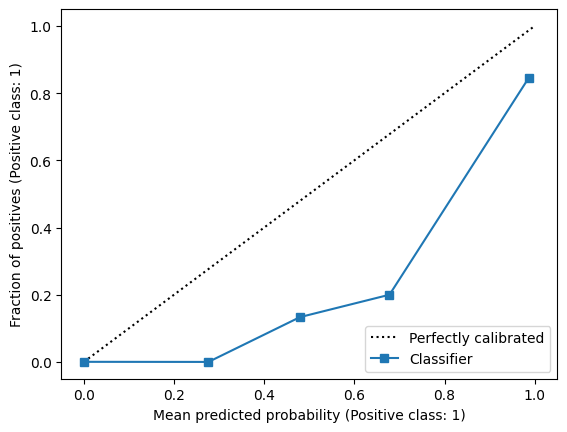

In [131]:
CalibrationDisplay.from_predictions(y_test,scores)

In [130]:
pd.Series(scores).describe()

count    7.120200e+04
mean     2.587874e-03
std      4.157602e-02
min      1.899853e-10
25%      6.004730e-06
50%      3.392117e-05
75%      1.919934e-04
max      9.999945e-01
dtype: float64

In [107]:
data_test['scores'] = scores
bin_var(data_test,'scores')

c:\Users\thoma\Documents\projects\fraud_detection\analysis\..\src\report.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby(col_binned).agg(


,scores_binned,count,bad,bad_rate,bad_distr
0,"(-0.001, 3.68e-05]",7121,3,0.000421,0.024390
1,"(3.68e-05, 6.75e-05]",7120,0,0.000000,0.000000
2,"(6.75e-05, 0.000101]",7120,1,0.000140,0.008130
3,"(0.000101, 0.000141]",7120,0,0.000000,0.000000
4,"(0.000141, 0.00019]",7120,1,0.000140,0.008130
5,"(0.00019, 0.000253]",7120,1,0.000140,0.008130
6,"(0.000253, 0.000338]",7120,0,0.000000,0.000000
7,"(0.000338, 0.000481]",7120,1,0.000140,0.008130
8,"(0.000481, 0.000822]",7120,2,0.000281,0.016260
9,"(0.000822, 1.0]",7121,114,0.016009,0.926829


In [124]:
from optbinning import OptimalBinning


In [137]:
optb = OptimalBinning(name='scores',max_n_bins=10, dtype="numerical", solver="cp")


In [138]:
optb.fit(scores,y_test)

OptimalBinning(max_n_bins=10, name='scores')

In [139]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.00)",52585,0.738533,52581,4,0.000076,3.124453,2.209719,0.200233
1,"[0.00, 0.00)",15056,0.211455,15051,5,0.000332,1.650399,0.282383,0.031769
2,"[0.00, inf)",3561,0.050013,3447,114,0.032013,-2.950302,2.591350,0.241613
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,71202,1.000000,71079,123,0.001727,,5.083453,0.473615
